In [1]:
!pip install gdown

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=baa2852fe7646a6adc98ed2d704269cb4b0864f06ecc5565cfa2d7959b473f75
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown


In [2]:
!rm -rf model_discovery
!rm -rf data
import gdown
# download source code
gdown.download('https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_', output=None, quiet=False)
# download data
gdown.download('https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i', output=None, quiet=False)

!unzip -qq data.zip
!unzip -qq model_discovery.zip

Downloading...
From: https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_
To: /kaggle/working/model_discovery.zip
100%|██████████| 11.9k/11.9k [00:00<00:00, 12.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i
To: /kaggle/working/data.zip
100%|██████████| 22.5M/22.5M [00:00<00:00, 209MB/s]


In [3]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import model_discovery
from collections import Counter, defaultdict
from importlib import reload
from matplotlib import gridspec
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from model_discovery import utils, l2lsh, my_timer



In [4]:
dir_path = './'
ar_data = np.load(dir_path + 'data/activity_recognition/activity_recognition_full.npy', allow_pickle=True).item()

In [5]:
datasets = ['dsads_t', 'dsads_ra', 'dsads_la', 
            'dsads_rl', 'dsads_ll', 'oppo_b', 
            'oppo_rua', 'oppo_rla', 'oppo_lua',
            'oppo_lla', 'pamap_w', 'pamap_c',
            'pamap_a']

# datasets = ['dsads_t', 'oppo_rua', 'pamap_a', 
#             'dsads_rl']

combinations = itertools.combinations(datasets,2)
combinations = list(combinations)

permutations = itertools.permutations(datasets,2)
permutations = list(permutations)

## Validate the JS-Divergence can be estimated by squared hellinger distance

proposed by 
```
Chen, L., Esfandiari, H., Fu, G., & Mirrokni, V. (2019). Locality-sensitive hashing for f-divergences: Mutual information loss and beyond. Advances in Neural Information Processing Systems, 32, 10044-10054.
```

In [6]:
# Figure JSD vs. HSD

jsd = []
shd = []

for comb in tqdm(combinations, leave=False):
    data1 = ar_data[comb[0]]
    data2 = ar_data[comb[1]]
    for i in range(data1.shape[1]):
        col1 = data1[:, i]
        col2 = data2[:, i]
        prob1 = utils.data_to_probability(col1, 100)
        prob2 = utils.data_to_probability(col2, 100)
        jsd.append(utils.jensen_shannon_divergence(prob1, prob2))
        shd.append(utils.squared_hellinger_distance(prob1, prob2))  

  0%|          | 0/78 [00:00<?, ?it/s]

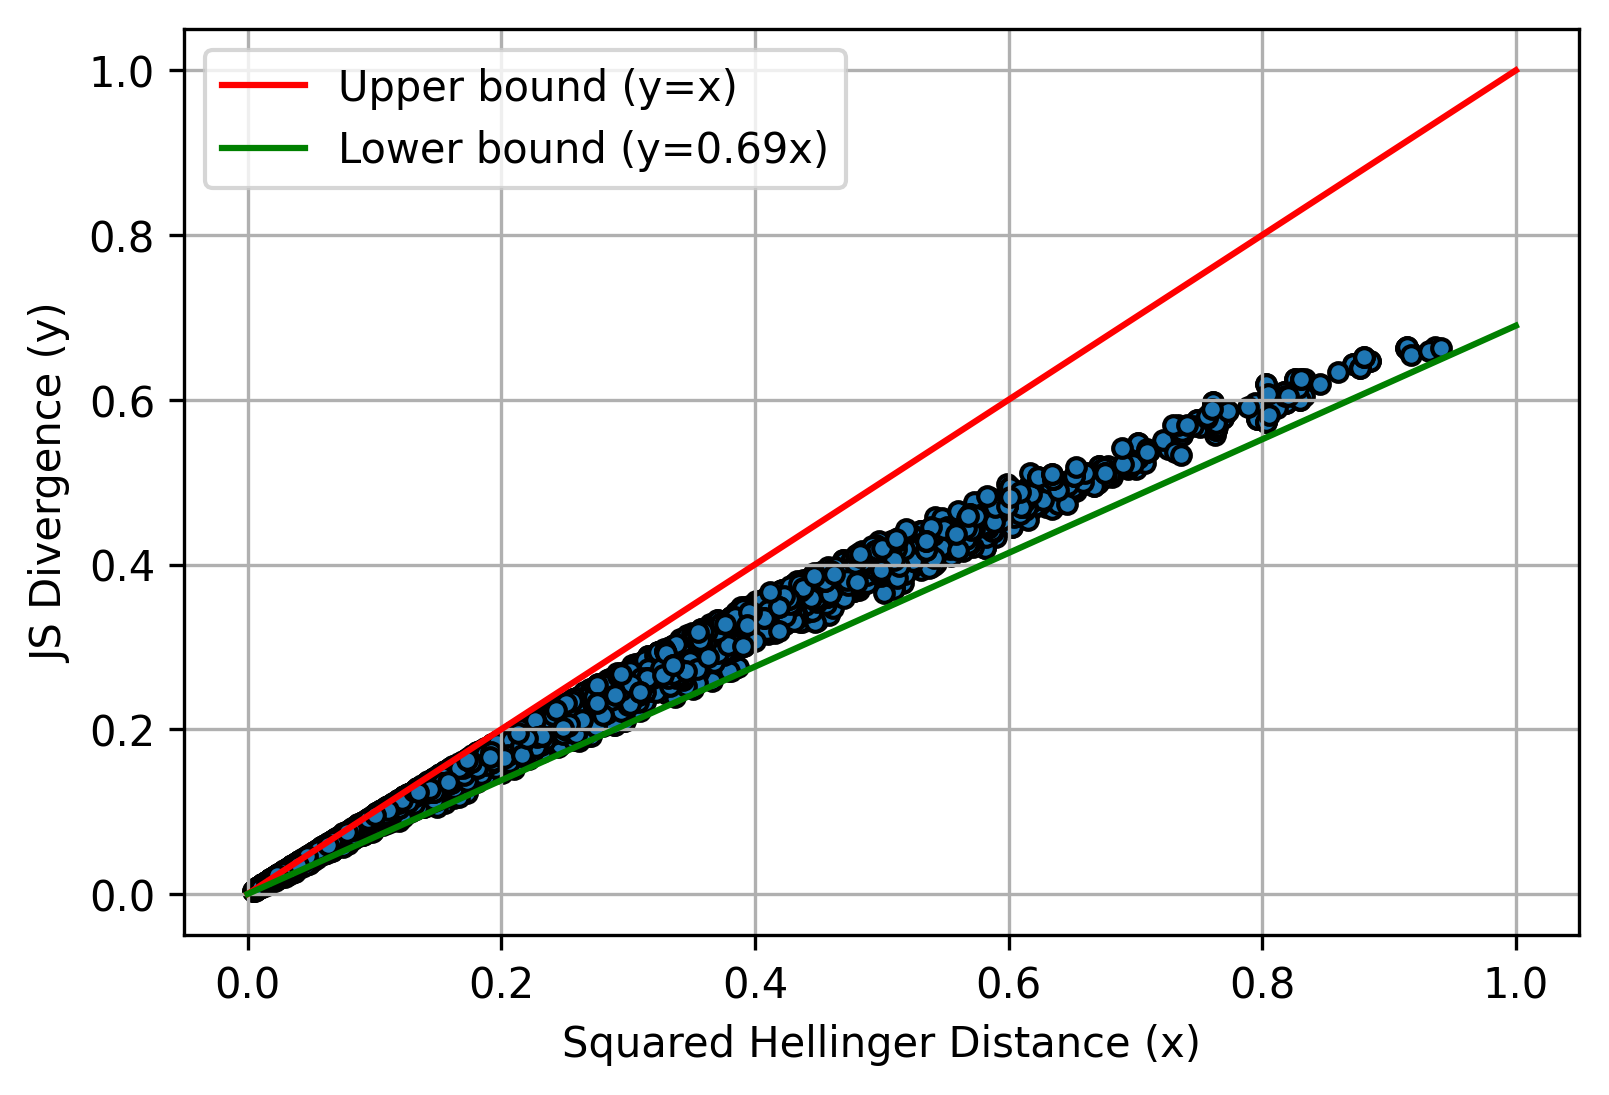

In [7]:
plt.figure(figsize=(6,4), dpi=300)
plt.scatter(shd, jsd, s=20, edgecolor='black')
a = np.linspace(0, 1, 100)
plt.grid()
plt.plot(a, a, c='red', label='Upper bound (y=x)')
plt.plot(a, 0.69*a, c='green', label='Lower bound (y=0.69x)')
plt.xlabel('Squared Hellinger Distance (x)')
plt.ylabel('JS Divergence (y)')
plt.legend()
plt.show()

In [8]:
len(ar_data['dsads_label'])

1920

In [9]:
arr_cache_trained_model=[]

def look_up_labels(data):
  if data in ['dsads_t', 'dsads_ra', 'dsads_la', 'dsads_rl', 'dsads_ll']:
    return 'dsads_label'
  elif data in ['oppo_b', 'oppo_rua', 'oppo_rla', 'oppo_lua', 'oppo_lla']:
    return 'oppo_label'
  elif data in ['pamap_w', 'pamap_c', 'pamap_a']:
    return 'pamap_label'

def nn_finetune(source_name,src_x, src_y, tar_x, tar_y, src_t_size=0.2, tar_t_size=0.8, verbose=0):

    filename = source_name+'_model'
    
    src_x_train, src_x_test, src_y_train, src_y_test = train_test_split(src_x, src_y, test_size=src_t_size, random_state=0)
    tar_x_train, tar_x_test, tar_y_train, tar_y_test = train_test_split(tar_x, tar_y, test_size=tar_t_size, random_state=0)

    input_size = src_x.shape[1]
    src_output_size = len(np.unique(src_y))
    tar_output_size = len(np.unique(tar_y))
    
    if filename not in arr_cache_trained_model:
        print("Training new model->",filename)
        model_src = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(input_size, 1)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(src_output_size, activation='softmax')
        ])

        model_src.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['mae', 'acc'])
        model_src.fit(src_x_train, src_y_train, epochs=15, verbose=verbose)
        print('Source Domain NN Accuracy')
        
    
    else:
        print("Already present model->",filename)
        model_src=tf.keras.models.load_model(filename)
        
    src_acc = model_src.evaluate(src_x_test, src_y_test, verbose=1)
    
    arr_cache_trained_model.append(filename)
    print(filename)
    model_src.save(filename)
    
    
    # Finetune
    model_tar = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_size, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(tar_output_size, activation='softmax')
    ])

    model_tar.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['mae', 'acc'])

    model_tar.layers[1].set_weights(model_src.layers[1].get_weights())
    model_tar.layers[1].trainable = False

    print('Serving Accuracy');
    ser_acc = model_src.evaluate(tar_x_test, tar_y_test, verbose=1)

    model_tar.fit(tar_x_train, tar_y_train, epochs=15, verbose=verbose)
    print('Fine-tunned model trained with tar domain size ', 1 - tar_t_size,
        'Train size: ', tar_x_train.shape[0], 'Test size: ', tar_x_test.shape[0])
    ft_acc = model_tar.evaluate(tar_x_test, tar_y_test, verbose=1)

    return [src_acc, ser_acc, ft_acc]

In [10]:
permutations

[('dsads_t', 'dsads_ra'),
 ('dsads_t', 'dsads_la'),
 ('dsads_t', 'dsads_rl'),
 ('dsads_t', 'dsads_ll'),
 ('dsads_t', 'oppo_b'),
 ('dsads_t', 'oppo_rua'),
 ('dsads_t', 'oppo_rla'),
 ('dsads_t', 'oppo_lua'),
 ('dsads_t', 'oppo_lla'),
 ('dsads_t', 'pamap_w'),
 ('dsads_t', 'pamap_c'),
 ('dsads_t', 'pamap_a'),
 ('dsads_ra', 'dsads_t'),
 ('dsads_ra', 'dsads_la'),
 ('dsads_ra', 'dsads_rl'),
 ('dsads_ra', 'dsads_ll'),
 ('dsads_ra', 'oppo_b'),
 ('dsads_ra', 'oppo_rua'),
 ('dsads_ra', 'oppo_rla'),
 ('dsads_ra', 'oppo_lua'),
 ('dsads_ra', 'oppo_lla'),
 ('dsads_ra', 'pamap_w'),
 ('dsads_ra', 'pamap_c'),
 ('dsads_ra', 'pamap_a'),
 ('dsads_la', 'dsads_t'),
 ('dsads_la', 'dsads_ra'),
 ('dsads_la', 'dsads_rl'),
 ('dsads_la', 'dsads_ll'),
 ('dsads_la', 'oppo_b'),
 ('dsads_la', 'oppo_rua'),
 ('dsads_la', 'oppo_rla'),
 ('dsads_la', 'oppo_lua'),
 ('dsads_la', 'oppo_lla'),
 ('dsads_la', 'pamap_w'),
 ('dsads_la', 'pamap_c'),
 ('dsads_la', 'pamap_a'),
 ('dsads_rl', 'dsads_t'),
 ('dsads_rl', 'dsads_ra'),
 ('d

In [11]:
# Figure exhaust combination of AR to compute JSD

src = []
tar = []
jsd = []
l2d = []
adp = []

source = [] 
serving = []
finetune = []

for comb in tqdm(permutations, leave=False):
    # Retrieve Data
    data1 = ar_data[comb[0]]
    data1_label = ar_data[look_up_labels(comb[0])]
    data2 = ar_data[comb[1]]
    data2_label = ar_data[look_up_labels(comb[1])]
    
    # Calculate JSD
    prob1 = utils.data_to_probability(data1, bins=100)
    prob2 = utils.data_to_probability(data2, bins=100)

    # Calculate L2D
    center1 = utils.data_to_center(data1)
    center2 = utils.data_to_center(data2)
    
    src.append(comb[0])
    tar.append(comb[1])
    jsd.append(utils.jensen_shannon_divergence(prob1, prob2))
    adp.append(utils.adaptivity(data1, data2, threshold=0.3))
    l2d.append(utils.l2_distance(center1, center2))

    accs = nn_finetune(comb[0],data1, data1_label, data2, data2_label,src_t_size=0.2, tar_t_size=0.8, verbose=0)
    source.append(accs[0][2])    
    serving.append(accs[1][2])
    finetune.append(accs[2][2])

  0%|          | 0/156 [00:00<?, ?it/s]

Training new model-> dsads_t_model


2022-04-12 18:53:21.641311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 18:53:21.724103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 18:53:21.724806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 18:53:21.725903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Source Domain NN Accuracy
12/12 [==============================] - 0s 2ms/step - loss: 0.7468 - mae: 1.3854 - acc: 0.6094
dsads_t_model


2022-04-12 18:53:26.527837: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Serving Accuracy
48/48 [==============================] - 0s 2ms/step - loss: 0.8154 - mae: 1.3799 - acc: 0.5716
Fine-tunned model trained with tar domain size  0.19999999999999996 Train size:  384 Test size:  1536
48/48 [==============================] - 0s 2ms/step - loss: 0.6542 - mae: 1.3799 - acc: 0.7057
Already present model-> dsads_t_model
12/12 [==============================] - 0s 2ms/step - loss: 0.7468 - mae: 1.3854 - acc: 0.6094
dsads_t_model
Serving Accuracy
48/48 [==============================] - 0s 2ms/step - loss: 0.8176 - mae: 1.3799 - acc: 0.6042
Fine-tunned model trained with tar domain size  0.19999999999999996 Train size:  384 Test size:  1536
48/48 [==============================] - 0s 2ms/step - loss: 0.6487 - mae: 1.3799 - acc: 0.7207
Already present model-> dsads_t_model
12/12 [==============================] - 0s 2ms/step - loss: 0.7468 - mae: 1.3854 - acc: 0.6094
dsads_t_model
Serving Accuracy
48/48 [==============================] - 0s 2ms/step - loss: 0.84

In [12]:
result_df = pd.DataFrame({'Source': src, 'Target': tar, 'l2d': l2d, 'jsd': jsd, 'Adaptivity':adp, 'Source Accuracy': source, 'serving': serving, 'finetune': finetune})

In [13]:
result_df

,Source,Target,l2d,jsd,Adaptivity,Source Accuracy,serving,finetune
0,dsads_t,dsads_ra,0.505051,0.017977,4.0,0.609375,0.571615,0.705729
1,dsads_t,dsads_la,0.778643,0.021905,4.0,0.609375,0.604167,0.720703
2,dsads_t,dsads_rl,0.479365,0.019388,4.0,0.609375,0.590495,0.648438
3,dsads_t,dsads_ll,0.509558,0.014866,4.0,0.609375,0.589844,0.632812
4,dsads_t,oppo_b,1.699683,0.087178,4.0,0.609375,0.341961,0.882778
...,...,...,...,...,...,...,...,...
151,pamap_a,oppo_rla,1.097437,0.062846,7.0,0.722675,0.270781,0.776755
152,pamap_a,oppo_lua,1.187925,0.056171,7.0,0.722675,0.279741,0.824291
153,pamap_a,oppo_lla,1.002996,0.062375,7.0,0.722675,0.237432,0.770533
154,pamap_a,pamap_w,0.743870,0.014660,7.0,0.722675,0.477356,0.729498


In [14]:
pd.set_option('display.max_rows', 200)
result_df=result_df.sort_values(by=['Target', 'serving'], ascending=False)
result_df

,Source,Target,l2d,jsd,Adaptivity,Source Accuracy,serving,finetune
142,pamap_c,pamap_w,0.622451,0.005972,7.0,0.898858,0.530804,0.734394
154,pamap_a,pamap_w,0.743870,0.014660,7.0,0.722675,0.477356,0.729498
57,dsads_ll,pamap_w,1.729038,0.044448,4.0,0.697917,0.337005,0.649939
45,dsads_rl,pamap_w,1.791822,0.048892,4.0,0.643229,0.241126,0.714810
9,dsads_t,pamap_w,1.713112,0.041491,4.0,0.609375,0.238678,0.692370
21,dsads_ra,pamap_w,1.578720,0.032859,4.0,0.747396,0.234598,0.692370
69,oppo_b,pamap_w,1.384871,0.041871,11.0,0.910448,0.234598,0.760914
81,oppo_rua,pamap_w,1.251849,0.052333,11.0,0.897512,0.234598,0.753978
105,oppo_lua,pamap_w,1.277806,0.051026,11.0,0.884577,0.234598,0.752754
117,oppo_lla,pamap_w,1.100290,0.049828,11.0,0.832836,0.159935,0.738474


In [15]:
datasets

['dsads_t',
 'dsads_ra',
 'dsads_la',
 'dsads_rl',
 'dsads_ll',
 'oppo_b',
 'oppo_rua',
 'oppo_rla',
 'oppo_lua',
 'oppo_lla',
 'pamap_w',
 'pamap_c',
 'pamap_a']

In [16]:
ar_data['dsads_t']

array([[1.8159e-01, 1.2891e-03, 9.7740e-01, ..., 3.5026e-04, 1.6672e-01,
        4.8733e-02],
       [1.8186e-01, 9.6067e-04, 9.7901e-01, ..., 1.6386e-03, 8.2052e-01,
        7.6149e-01],
       [1.8171e-01, 5.2793e-04, 9.9120e-01, ..., 2.5491e-04, 1.8438e-01,
        7.9390e-02],
       ...,
       [1.9397e-01, 1.0257e-01, 5.6145e-01, ..., 1.5153e-02, 5.6430e-01,
        3.8648e-01],
       [2.0082e-01, 1.0653e-01, 5.4812e-01, ..., 2.6152e-02, 6.2379e-01,
        4.1909e-01],
       [1.8725e-01, 1.0268e-01, 5.5722e-01, ..., 1.4752e-02, 5.8800e-01,
        4.2501e-01]])

In [17]:
tf.keras.models.Sequential.predict

<function keras.engine.training.Model.predict(self, x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)>

In [18]:
metrics=['jsd','Adaptivity','l2d','Source Accuracy']
metric_dic={}
for m in metrics:
    temp_df=[]
#     print("--------")
    target_dict_max_voting={}
    for target in datasets:
        
        temp_df = result_df[result_df['Target']==target][['Source','Target',m]]
        if m=='Adaptivity' or m=='Source Accuracy':
            temp_df= temp_df.nlargest(3, m)
        else:
            temp_df= temp_df.nsmallest(3, m)
        print("TARGET-",target)
#         print(temp_df)
        dict_predict_curr={}
        for src in temp_df['Source'].values:
            # Model Save
#             print("src")
#             print(src)
            file_name = src+"_model"
            print(file_name)
            if file_name in arr_cache_trained_model: # model is already saved
                model_src=tf.keras.models.load_model(file_name)
                print("")
                print("Weights Loaded-      ",file_name)
            print("Target dataset loaded-    ",target)
            x_train_target = ar_data[target]
            y_pred = model_src.predict(x_train_target) 
#             print("y_pred--->",y_pred)
            output_pred = np.argmax(y_pred, axis=1)
#             print("output_pred--->",output_pred)
            dict_predict_curr[src]=output_pred
            print(len(output_pred))
        print(dict_predict_curr)
        
#         {'dsads_rl': array([2, 2, 2, ..., 3, 0, 3]), 'pamap_a': array([1, 1, 1, ..., 3, 3, 3]), 'oppo_rua': array([3, 3, 3, ..., 3, 3, 3])}
        
        
        
        
        sum_arr=[]
        for val in range(len(output_pred)):
            arr_max_voting_freq=[]
            for model_ in dict_predict_curr:
                arr_max_voting_freq.append(dict_predict_curr[model_][val])
            sum_arr.append(np.bincount(arr_max_voting_freq).argmax())    
        max_voted_arr = sum_arr
#         print("vote freq arr-", max_voted_arr)
        max_voted_model={}
        for source_model in dict_predict_curr:
            print(source_model,"-->",target)
            for i,val in enumerate(dict_predict_curr[source_model]):
                if max_voted_arr[i]==val:
                    if source_model in max_voted_model:
                        max_voted_model[source_model]+=1
                    else:
                        max_voted_model[source_model]=1
            max_voted_model[source_model]=max_voted_model[source_model]/len(output_pred)
        print(max_voted_model)
        
        ####
        # creating target dict
        target_dict_max_voting[target]=max_voted_model
    print(target_dict_max_voting)
    metric_dic[m]=target_dict_max_voting
print("----##----")
print(metric_dic)

TARGET- dsads_t
dsads_ll_model

Weights Loaded-       dsads_ll_model
Target dataset loaded-     dsads_t
1920
dsads_ra_model

Weights Loaded-       dsads_ra_model
Target dataset loaded-     dsads_t
1920
dsads_rl_model

Weights Loaded-       dsads_rl_model
Target dataset loaded-     dsads_t
1920
{'dsads_ll': array([0, 2, 2, ..., 3, 3, 3]), 'dsads_ra': array([2, 2, 2, ..., 3, 3, 3]), 'dsads_rl': array([2, 2, 2, ..., 3, 0, 3])}
dsads_ll --> dsads_t
dsads_ra --> dsads_t
dsads_rl --> dsads_t
{'dsads_ll': 0.8817708333333333, 'dsads_ra': 0.5630208333333333, 'dsads_rl': 0.7572916666666667}
TARGET- dsads_ra
dsads_la_model

Weights Loaded-       dsads_la_model
Target dataset loaded-     dsads_ra
1920
dsads_ll_model

Weights Loaded-       dsads_ll_model
Target dataset loaded-     dsads_ra
1920
dsads_rl_model

Weights Loaded-       dsads_rl_model
Target dataset loaded-     dsads_ra
1920
{'dsads_la': array([1, 1, 0, ..., 3, 3, 3]), 'dsads_ll': array([2, 1, 0, ..., 3, 3, 3]), 'dsads_rl': array([2, 2,

In [19]:
import json

df=result_df

for metric in metric_dic:
    for target in metric_dic[str(metric)]:
        for source in metric_dic[str(metric)][str(target)]:
            index = df.index[(df["Source"] == str(source)) & (df["Target"] == str(target))]
            df.loc[index[0], 'max_voting_'+metric+"_%"] = (metric_dic[str(metric)][str(target)][str(source)])*100

df.to_csv('Max_Voting_Activity_Recognition_Result.csv')

In [20]:
df

,Source,Target,l2d,jsd,Adaptivity,Source Accuracy,serving,finetune,max_voting_jsd_%,max_voting_Adaptivity_%,max_voting_l2d_%,max_voting_Source Accuracy_%
142,pamap_c,pamap_w,0.622451,0.005972,7.0,0.898858,0.530804,0.734394,80.215475,NaN,78.223963,6.594842
154,pamap_a,pamap_w,0.743870,0.014660,7.0,0.722675,0.477356,0.729498,70.649690,NaN,80.476657,NaN
57,dsads_ll,pamap_w,1.729038,0.044448,4.0,0.697917,0.337005,0.649939,NaN,NaN,NaN,NaN
45,dsads_rl,pamap_w,1.791822,0.048892,4.0,0.643229,0.241126,0.714810,NaN,NaN,NaN,NaN
9,dsads_t,pamap_w,1.713112,0.041491,4.0,0.609375,0.238678,0.692370,NaN,NaN,NaN,NaN
21,dsads_ra,pamap_w,1.578720,0.032859,4.0,0.747396,0.234598,0.692370,NaN,NaN,NaN,NaN
69,oppo_b,pamap_w,1.384871,0.041871,11.0,0.910448,0.234598,0.760914,NaN,99.869409,NaN,99.771466
81,oppo_rua,pamap_w,1.251849,0.052333,11.0,0.897512,0.234598,0.753978,NaN,99.869409,NaN,99.771466
105,oppo_lua,pamap_w,1.277806,0.051026,11.0,0.884577,0.234598,0.752754,NaN,99.934705,NaN,NaN
117,oppo_lla,pamap_w,1.100290,0.049828,11.0,0.832836,0.159935,0.738474,NaN,NaN,22.494287,NaN
